In [5]:
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from pathlib import Path

# Remove any existing config imports to avoid conflicts
if 'config' in sys.modules:
    del sys.modules['config']

# Setup YAML configuration using notebook_config helper
current_path = Path.cwd()
project_root = current_path.parent  # notebooks is in project_root/notebooks

# Add project root to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import notebook config helper
from notebook_config import setup_notebook_config
config = setup_notebook_config()

# Set plot style
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.family"] = 'sans-serif'

print("\nLoading datasets...")

# Load summarization dataset
try:
    summ_data = load_dataset('csv', data_files=str(config.summarization_data))
    df_summ = summ_data['train'].to_pandas()
    print(f"Summarization dataset loaded: {len(df_summ)} samples")
except Exception as e:
    print(f"Error loading summarization dataset: {e}")
    summ_data = None
    df_summ = None

# Load sentiment dataset
try:
    sent_data = load_dataset('csv', data_files=str(config.sentiment_data))
    df_sent = sent_data['train'].to_pandas()
    print(f"Sentiment dataset loaded: {len(df_sent)} samples")
except Exception as e:
    print(f"Error loading sentiment dataset: {e}")
    sent_data = None
    df_sent = None

print("Setup complete!")

Configuration loaded from d:\Project\MajorProject\config.yaml
Configuration loaded from: d:\Project\MajorProject\config.yaml
Project root: d:\Project\MajorProject

Loading datasets...


Generating train split: 0 examples [00:00, ? examples/s]

Summarization dataset loaded: 43943 samples


Generating train split: 0 examples [00:00, ? examples/s]

Sentiment dataset loaded: 31460 samples
Setup complete!


Summarization Dataset Analysis:

Dataset shape: (43943, 2)
Columns: ['Contents', 'Summary']

Text Length Statistics:
Average content length: 503.3 words
Average summary length: 41.8 words
Average compression ratio: 0.116

Sample Content:
Content (367 words):
Chiều 15.6, ông Nguyễn Viết Hiển - Giám đốc Sở GDĐT Thái Bình cho biết: Về tiến độ cập nhập điểm thi, đến 16h chiều nay, bộ phận kiểm dò, lên điểm của kỳ thi tuyển sinh vào lớp 10 công lập tỉnh này vẫn đang làm việc liên tục để sớm công bố điểm thi của các thí sinh. Tuy nhiên, trong khi điểm thi còn...

Summary (51 words):
Dù chưa công bố điểm thi nhưng một bảng điểm được ghi là điểm chuẩn duyệt tuyển sinh lớp 10 THPT công lập năm 2019-2020 của tỉnh Thái Bình đã được lan truyền với tốc độ chóng mặt. Lãnh đạo Sở GDĐT Thái Bình khẳng định đó bảng điểm chuẩn giả.

Generating visualizations...

Text Length Statistics:
Average content length: 503.3 words
Average summary length: 41.8 words
Average compression ratio: 0.116

Sample Content

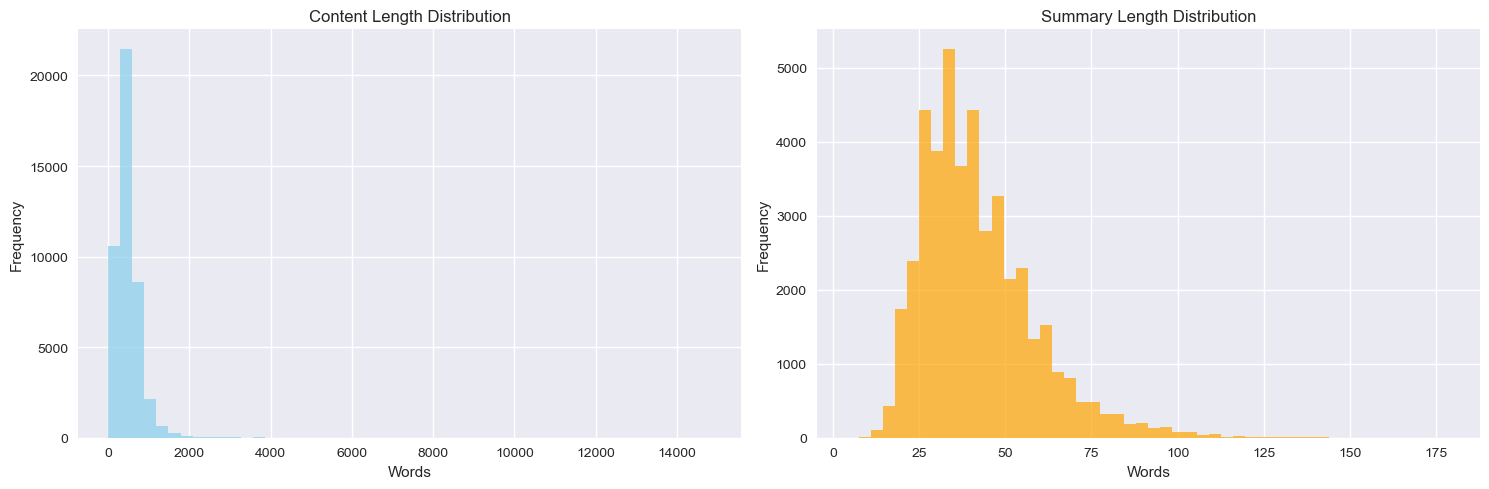

In [6]:
# Data Analysis for Summarization Dataset
if df_summ is not None:
    print("Summarization Dataset Analysis:")
    print()
    
    # Basic dataset info
    print(f"Dataset shape: {df_summ.shape}")
    print(f"Columns: {list(df_summ.columns)}")
    
    # Text length analysis
    if 'Contents' in df_summ.columns and 'Summary' in df_summ.columns:
        df_summ['contents_len'] = df_summ['Contents'].str.split().str.len()
        df_summ['summary_len'] = df_summ['Summary'].str.split().str.len()
        df_summ['compression_ratio'] = df_summ['summary_len'] / df_summ['contents_len']
        
        print(f"\nText Length Statistics:")
        print(f"Average content length: {df_summ['contents_len'].mean():.1f} words")
        print(f"Average summary length: {df_summ['summary_len'].mean():.1f} words")
        print(f"Average compression ratio: {df_summ['compression_ratio'].mean():.3f}")
        
        # Sample content
        print(f"\nSample Content:")
        sample_idx = 0
        print(f"Content ({df_summ.iloc[sample_idx]['contents_len']} words):")
        print(f"{df_summ.iloc[sample_idx]['Contents'][:300]}...")
        print(f"\nSummary ({df_summ.iloc[sample_idx]['summary_len']} words):")
        print(f"{df_summ.iloc[sample_idx]['Summary']}")
        
        print(f"\nGenerating visualizations...")
        # Create simple visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Content length distribution
        axes[0].hist(df_summ['contents_len'], bins=50, alpha=0.7, color='skyblue')
        axes[0].set_title('Content Length Distribution')
        axes[0].set_xlabel('Words')
        axes[0].set_ylabel('Frequency')
        
        # Summary length distribution
        axes[1].hist(df_summ['summary_len'], bins=50, alpha=0.7, color='orange')
        axes[1].set_title('Summary Length Distribution')
        axes[1].set_xlabel('Words')
        axes[1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Required columns 'Contents' and 'Summary' not found")
else:
    print("Summarization dataset not available")

Sentiment Dataset Analysis:

Dataset shape: (31460, 4)
Columns: ['comment', 'label', 'rate', 'Unnamed: 3']

Text Length Statistics:
Average comment length: 7.1 words
Min length: 1 words
Max length: 64 words

Label Distribution:
  POS: 20093 samples (63.9%)
  NEG: 6669 samples (21.2%)
  NEU: 4698 samples (14.9%)

Sample Comments by Label:
  POS: Áo bao đẹp ạ!!...
  NEG: 2day ao khong giong trong....
  NEU: Mặc đc....

Generating visualizations...


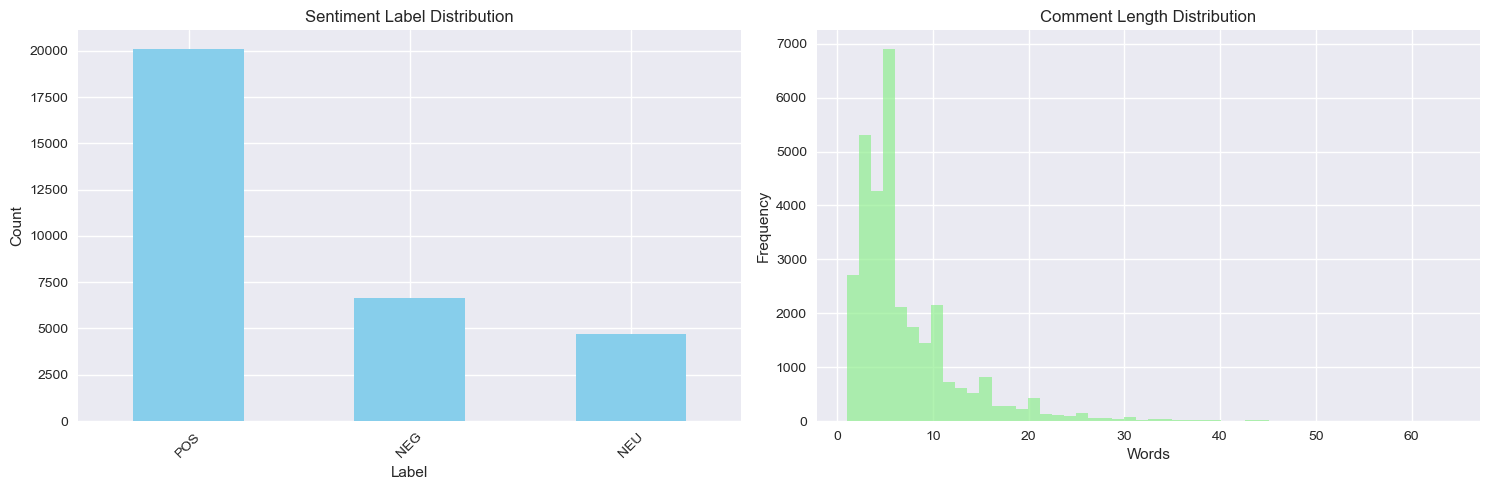

In [7]:
# Data Analysis for Sentiment Dataset
if df_sent is not None:
    print("Sentiment Dataset Analysis:")
    print()
    
    # Basic dataset info
    print(f"Dataset shape: {df_sent.shape}")
    print(f"Columns: {list(df_sent.columns)}")
    
    # Text analysis
    if 'comment' in df_sent.columns:
        df_sent['text_len'] = df_sent['comment'].str.split().str.len()
        
        print(f"\nText Length Statistics:")
        print(f"Average comment length: {df_sent['text_len'].mean():.1f} words")
        print(f"Min length: {df_sent['text_len'].min()} words")
        print(f"Max length: {df_sent['text_len'].max()} words")
        
        # Label analysis
        if 'label' in df_sent.columns:
            print(f"\nLabel Distribution:")
            label_counts = df_sent['label'].value_counts()
            for label, count in label_counts.items():
                percentage = (count / len(df_sent)) * 100
                print(f"  {label}: {count} samples ({percentage:.1f}%)")
            
            # Sample comments by label
            print(f"\nSample Comments by Label:")
            for label in df_sent['label'].unique():
                sample = df_sent[df_sent['label'] == label].iloc[0]
                print(f"  {label}: {sample['comment'][:100]}...")
        
        print(f"\nGenerating visualizations...")
        # Create visualizations
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Label distribution
        if 'label' in df_sent.columns:
            label_counts.plot(kind='bar', ax=axes[0], color='skyblue')
            axes[0].set_title('Sentiment Label Distribution')
            axes[0].set_xlabel('Label')
            axes[0].set_ylabel('Count')
            axes[0].tick_params(axis='x', rotation=45)
        
        # Text length distribution
        axes[1].hist(df_sent['text_len'], bins=50, alpha=0.7, color='lightgreen')
        axes[1].set_title('Comment Length Distribution')
        axes[1].set_xlabel('Words')
        axes[1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Required column 'comment' not found")
else:
    print("Sentiment dataset not available")

Cross-Dataset Analysis:

Dataset Comparison:
  Summarization dataset: 43,943 samples
  Sentiment dataset: 31,460 samples

Average Text Lengths:
  Summarization content: 503.3 words
  Summarization summary: 41.8 words
  Sentiment comments: 7.1 words

Compression Analysis:
  Average compression ratio: 0.116
  Summaries are 11.6% of original length

Data Quality Summary:
  Summarization dataset:
    - Content quality (>10 words): 99.9%
    - Summary quality (>3 words): 100.0%
  Sentiment dataset:
    - Comment quality (>5 words): 48.1%
    - Label imbalance ratio: 4.3:1

Generating cross-dataset comparison...


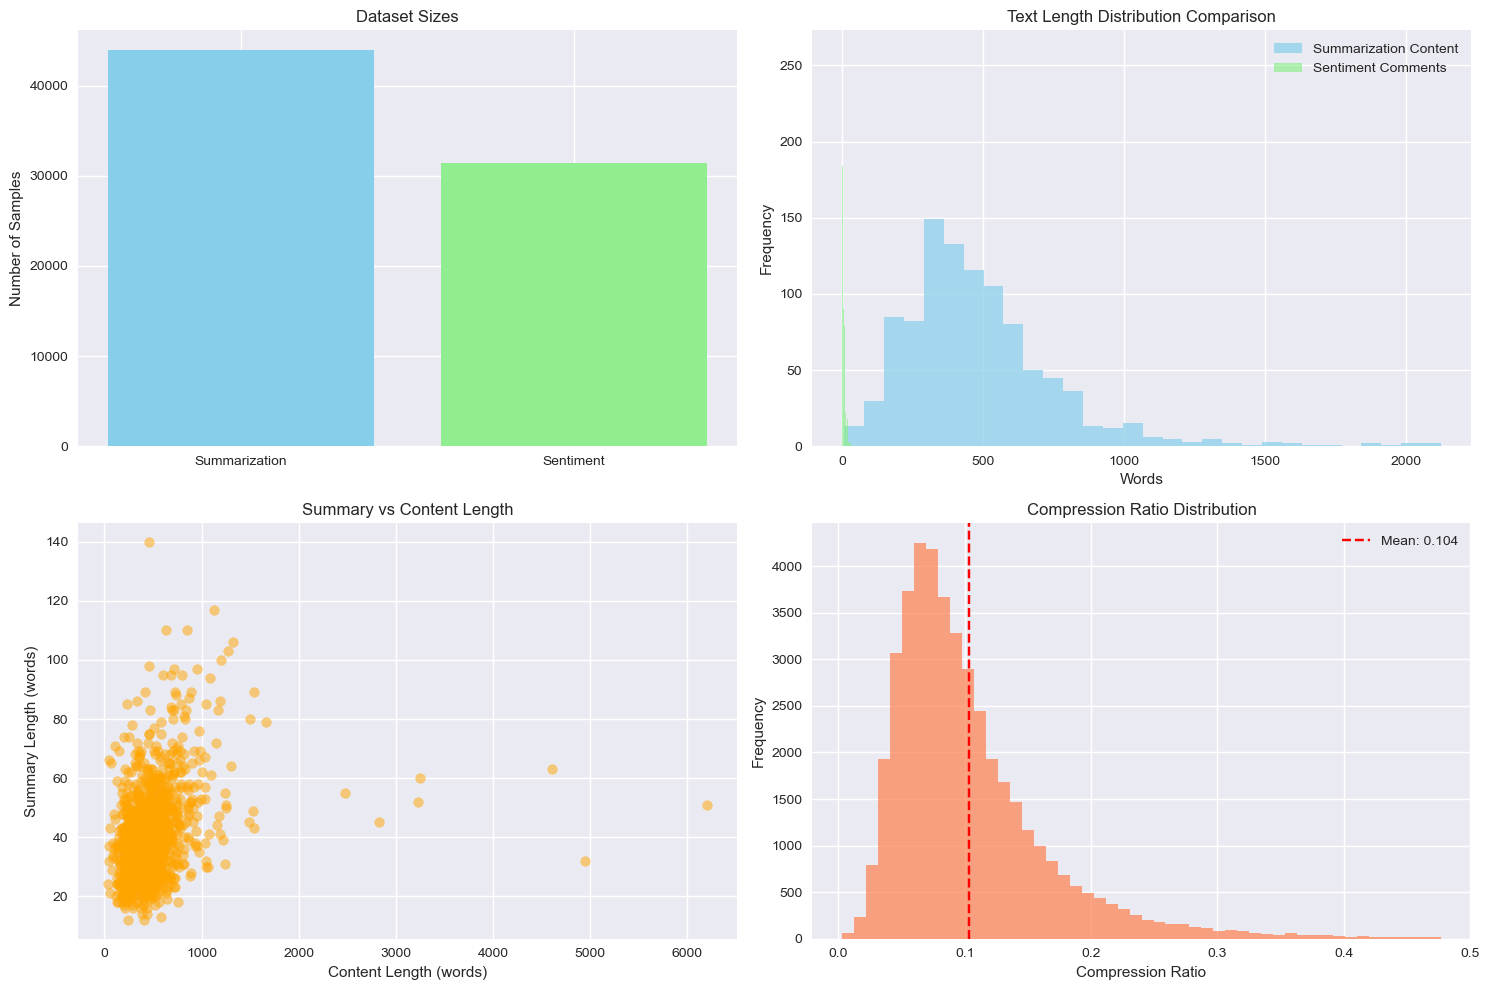


Analysis complete!


In [ ]:
# Cross-Dataset Analysis
if df_summ is not None and df_sent is not None:
    print("Cross-Dataset Analysis:")
    print("=" * 50)
    
    # Compare basic statistics
    print(f"\nDataset Comparison:")
    print(f"  Summarization dataset: {len(df_summ):,} samples")
    print(f"  Sentiment dataset: {len(df_sent):,} samples")
    
    # Text length comparison
    if 'contents_len' in df_summ.columns and 'text_len' in df_sent.columns:
        print(f"\nAverage Text Lengths:")
        print(f"  Summarization content: {df_summ['contents_len'].mean():.1f} words")
        if 'summary_len' in df_summ.columns:
            print(f"  Summarization summary: {df_summ['summary_len'].mean():.1f} words")
        print(f"  Sentiment comments: {df_sent['text_len'].mean():.1f} words")
        
        # Compression analysis
        if 'compression_ratio' in df_summ.columns:
            avg_compression = df_summ['compression_ratio'].mean()
            print(f"\nCompression Analysis:")
            print(f"  Average compression ratio: {avg_compression:.3f}")
            print(f"  Summaries are {avg_compression*100:.1f}% of original length")
    
    # Data quality comparison
    print(f"\nData Quality Summary:")
    
    if 'contents_len' in df_summ.columns and 'summary_len' in df_summ.columns:
        content_quality = (df_summ['contents_len'] > 10).mean()
        summary_quality = (df_summ['summary_len'] > 3).mean()
        print(f"  Summarization dataset:")
        print(f"    - Content quality (>10 words): {content_quality:.1%}")
        print(f"    - Summary quality (>3 words): {summary_quality:.1%}")
    
    if 'text_len' in df_sent.columns:
        comment_quality = (df_sent['text_len'] > 5).mean()
        print(f"  Sentiment dataset:")
        print(f"    - Comment quality (>5 words): {comment_quality:.1%}")
        
        if 'label' in df_sent.columns:
            label_counts = df_sent['label'].value_counts()
            imbalance_ratio = label_counts.max() / label_counts.min()
            print(f"    - Label imbalance ratio: {imbalance_ratio:.1f}:1")
    
    # Visual comparison
    print(f"\nGenerating cross-dataset comparison...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Dataset sizes
    datasets = ['Summarization', 'Sentiment']
    sizes = [len(df_summ), len(df_sent)]
    axes[0,0].bar(datasets, sizes, color=['skyblue', 'lightgreen'])
    axes[0,0].set_title('Dataset Sizes')
    axes[0,0].set_ylabel('Number of Samples')
    
    # Text length comparison
    if 'contents_len' in df_summ.columns and 'text_len' in df_sent.columns:
        all_lengths = []
        all_labels = []
        
        # Sample to make comparison fair
        sample_size = min(1000, len(df_summ), len(df_sent))
        
        summ_sample = df_summ.sample(sample_size)['contents_len']
        sent_sample = df_sent.sample(sample_size)['text_len']
        
        axes[0,1].hist(summ_sample, alpha=0.7, label='Summarization Content', bins=30, color='skyblue')
        axes[0,1].hist(sent_sample, alpha=0.7, label='Sentiment Comments', bins=30, color='lightgreen')
        axes[0,1].set_title('Text Length Distribution Comparison')
        axes[0,1].set_xlabel('Words')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()
    
    # Summary vs Content length relationship
    if 'contents_len' in df_summ.columns and 'summary_len' in df_summ.columns:
        sample_data = df_summ.sample(min(1000, len(df_summ)))
        axes[1,0].scatter(sample_data['contents_len'], sample_data['summary_len'], 
                         alpha=0.5, color='orange')
        axes[1,0].set_title('Summary vs Content Length')
        axes[1,0].set_xlabel('Content Length (words)')
        axes[1,0].set_ylabel('Summary Length (words)')
    
    # Compression ratio distribution
    if 'compression_ratio' in df_summ.columns:
        compression_data = df_summ['compression_ratio']
        # Remove outliers for better visualization
        q99 = compression_data.quantile(0.99)
        filtered_data = compression_data[compression_data <= q99]
        
        axes[1,1].hist(filtered_data, bins=50, alpha=0.7, color='coral')
        axes[1,1].axvline(filtered_data.mean(), color='red', linestyle='--', 
                         label=f'Mean: {filtered_data.mean():.3f}')
        axes[1,1].set_title('Compression Ratio Distribution')
        axes[1,1].set_xlabel('Compression Ratio')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot perform cross-dataset analysis - one or both datasets failed to load")